In [1]:
import pm4py
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from pm4py.algo.evaluation.earth_mover_distance import algorithm as earth_mover_distance

/home/lennc/.local/lib/python3.11/site-packages/pm4py/algo/evaluation/earth_mover_distance/__init__.py:21: UserWarning: The earth_mover_distance package will be removed in a future release.
  warnings.warn("The earth_mover_distance package will be removed in a future release.")


In [2]:
file_name = "BPI_Challenge_2018"
attribute_key = "amount_applied0"

In [3]:
case_attribute_key = f'case:{attribute_key}'
case_id_key = "case:concept:name"

# df = pm4py.read_xes(f'../logs/{file_name}.xes')
df = pd.read_csv(f'../logs/{file_name}.{attribute_key}.csv')
df["time:timestamp"] = pd.to_datetime(df['time:timestamp'])
df["case:concept:name"] = df['case:concept:name'].astype(str)
df["concept:name"] = df['concept:name'].astype(str)

df = df.dropna(subset=[case_attribute_key]).reset_index() # filter empty rows

In [4]:
attribute_values = pm4py.get_trace_attribute_values(df, attribute_key)
sorted_attribute_values = sorted([ float(k) for k in attribute_values.keys() ])

# group df by case ids
grouped = df.filter([case_id_key, case_attribute_key]).groupby(case_id_key, sort=False)

In [5]:
df_gte_light = grouped.first() # initial gte group

# define absolute languages (counting the occurrence of cases)
# devide absoulte numbers by total number of cases later(!), otherwise every values has to be updated
language_lt = {}
language_gte = pm4py.stats.get_variants(df)

lt_sizes = []
gte_sizes = []

t = time.time()

for pivot in tqdm(sorted_attribute_values[1:]):

    # find affected cases
    df_affected_light_idx = df_gte_light[df_gte_light[case_attribute_key] < pivot].index

    # remove affected cases from gte group
    df_gte_light.drop(df_affected_light_idx, inplace=True)

    # translate into full df
    df_affected = pd.concat([ df.loc[grouped.indices[i]] for i in df_affected_light_idx ])

    # update absoulte languages
    for tr, n in pm4py.stats.get_variants(df_affected).items():
        language_lt[tr] = language_lt.setdefault(tr, 0) + n
        language_gte[tr] = language_gte[tr] - n

    language_lt_size = sum(language_lt.values(), 0.0)
    language_gte_size = sum(language_gte.values(), 0.0)

    # collect data to plot graph
    lt_sizes.append(language_lt_size)
    gte_sizes.append(language_gte_size)

t = time.time() - t

time.sleep(1)

print(f"time elapsed: {t}")

100%|██████████| 439/439 [00:08<00:00, 50.87it/s]


time elapsed: 8.643500089645386


In [6]:
# total number of traces
total = len(grouped.first().index)

# compute relative frequency of traces with certain attribute values
abs_freq = grouped.first().assign(n=1).groupby([case_attribute_key]).count()["n"].tolist() # get number of traces traces with same attribute value
rel_freq = [ v / total for v in abs_freq ]

# convert language sizes to relative sizes
rel_lt_sizes = [ s / total for s in lt_sizes ]
rel_gte_sizes = [ s / total for s in gte_sizes ]

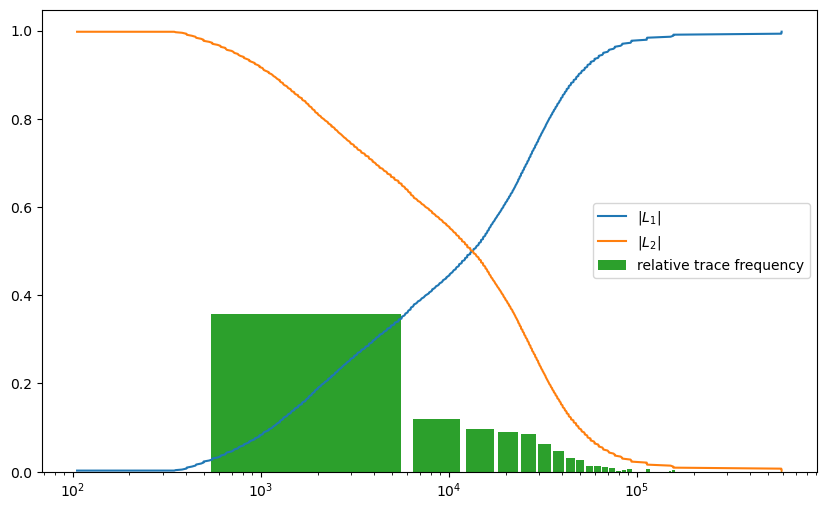

In [7]:
plt.figure(figsize=(10,6))

# plot mmlngld
plt.xscale("log")
plt.plot(sorted_attribute_values[1:], rel_lt_sizes, label=r"$|L_1|$")
plt.plot(sorted_attribute_values[1:], rel_gte_sizes, label=r"$|L_2|$")
plt.hist(sorted_attribute_values[1:], bins=100, weights=rel_freq[1:], rwidth=0.85, label="relative trace frequency")
plt.legend()
plt.savefig(f"out.stats.{file_name}.{attribute_key}.png", bbox_inches="tight")

In [8]:
print(f"min value: {sorted_attribute_values[0]} (occ: {lt_sizes[2]})")
print(f"min value: {sorted_attribute_values[1:][-1]} (occ: {gte_sizes[-1]})")

min value: 0.0 (occ: 153.0)
min value: 587772.08 (occ: 100.0)


In [9]:
pd.DataFrame({"l1": rel_lt_sizes, "l2": rel_gte_sizes, "rf": rel_freq[1:]}).to_csv(f"out.stats.{file_name}.{attribute_key}.csv", index=False, header=False)

In [10]:
df = pd.read_csv("out.emsc.PrepaidTravelCost.RequestedAmount.mt.csv", header=None, names=["emsc"])

In [11]:
print([ i for i, x in enumerate(sorted_attribute_values[1:]) if x < 1000])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]


In [12]:
(1 - df["emsc"][1565:2042]).idxmin()

2040

In [13]:
1 - df["emsc"][2040]

0.6827475113509986

In [15]:
sorted_attribute_values[1:][2040]

IndexError: list index out of range

In [16]:
sorted_attribute_values[1:][2]

351.78

In [17]:
df_stats = pd.read_csv("out.stats.PrepaidTravelCost.RequestedAmount.csv", header=None, names=["l1","l2","rf"])

In [18]:
df_stats["l1"][2] * 2099

2.9999999999999964

In [19]:
df_stats["l2"][2040] * 2099

8.99999999999999

ValueError: x and y must have same first dimension, but have shapes (439,) and (2048,)

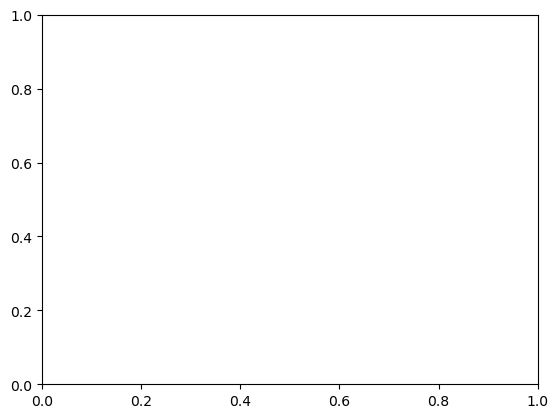

In [20]:
plt.plot(sorted_attribute_values[1:], 1 - df["emsc"])
plt.plot
plt.xscale("log")

In [27]:
df_m = pd.read_csv("out.mmlngld.BPI_Challenge_2018.amount_applied0.mt.csv", header=None, names=["d","s1","s2"])

In [28]:
df_stats = pd.read_csv("out.stats.BPI_Challenge_2018.amount_applied0.csv", header=None, names=["l1","l2","rf"])

In [35]:
df_m["mmlngld"] = [ 1 - (d + (2 - s1 - s2) / 2) / 2 for d, s1, s2 in zip(df_m["d"], df_m["s1"], df_m["s2"]) ]
df_m = df_m.reset_index()

In [36]:
df_m["mmlngld"].idxmin()

2

In [37]:
df_m["mmlngld"]

0      0.500315
1      0.499692
2      0.492802
3      0.500005
4      0.520829
         ...   
434    0.552291
435    0.557098
436    0.560622
437    0.559353
438    0.558491
Name: mmlngld, Length: 439, dtype: float64

In [41]:
df_stats["l1"][2] * 438009

1529.71711292198

In [42]:
sorted_attribute_values[2]

346.16

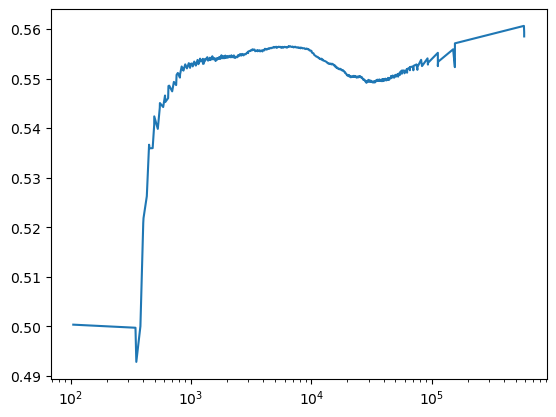

In [38]:
plt.plot(sorted_attribute_values[1:], df_m["mmlngld"])
plt.xscale("log")